# Weather Types

In this notebook we will start by computing weather types.
Then, we will look at composite anomalies and sequences of weather types that result from the calculation.

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from paraguayfloodspy.weather_type import XrEofCluster
from paraguayfloodspy.pars import GetPars

In [2]:
%matplotlib inline

Load in the raw data -- in this case, anomalies of streamfunction

In [3]:
pars = GetPars('all')
ds = xr.open_dataset("../_data/reanalysis/subset/streamfunc_850_anom.nc")
ds = ds.sel(lat = slice(pars['wt_rgn']['latmax'], pars['wt_rgn']['latmin']), 
            lon = slice(pars['wt_rgn']['lonmin'], pars['wt_rgn']['lonmax']), 
            time = slice('{}-11-01'.format(pars['time']['syear']), '{}-02-29'.format(pars['time']['eyear'])))

In [4]:
savefigs = True

## How Many Weather Types?

The weather typing algorithm is performed using the `XrEofCluster` algorithm.
Our first step is to explore several reasonable values for the number of weather types and then to explore the Classifiability Index associated with each.

In [5]:
n_clusters = np.arange(3,9)
class_index = np.zeros(n_clusters.shape)
for i,nc in enumerate(n_clusters):
    _, _, ci = XrEofCluster(
        ds, 
        n_clusters=nc, # How many weather types to create?
        prop=0.95, # What proportion of variance should be retained?
        nsim=50, # How many random initializations to compute?
        variable='streamfunction',
        verbose = False # get useful info from the algorithm
    )
    class_index[i] = ci

/usr/local/miniconda3/envs/pyfloods/lib/python3.6/site-packages/eofs/xarray.py:413: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  attrs={'long_name': 'eof_mode_number'})
/usr/local/miniconda3/envs/pyfloods/lib/python3.6/site-packages/eofs/xarray.py:178: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  attrs={'long_name': 'eof_mode_number'})


Number of EOFs retained is 4
Number of EOFs retained is 4
Number of EOFs retained is 4
Number of EOFs retained is 4
Number of EOFs retained is 4
Number of EOFs retained is 4


Let's see how these possibilities compare:

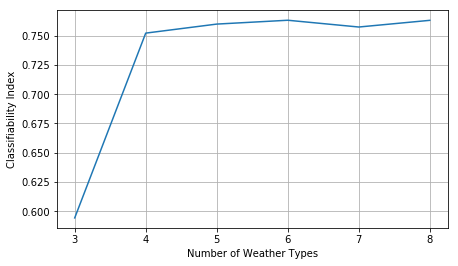

In [6]:
plt.figure(figsize=(7, 4))
plt.plot(n_clusters, class_index)
plt.xlabel("Number of Weather Types")
plt.ylabel("Classifiability Index")
plt.grid()
if savefigs:
    plt.savefig("../_figs/WT_Classifiability.pdf")

So, while 50 simulations is obviously less than ideal to see what the optimal classifiability index is, we see that anything in the range 4-7 is reasonable.
Although 4 provides the most stable estimates of the weather types, we choose $k=6$ because of the interpretability of the resulting weather types; this is a somewhat subjective choice but we feel a reasonable one.

## Weather Typing

Now we calculate the sequences of weather types

In [7]:
best_centroid, best_ts, classifiability = XrEofCluster(
    ds, 
    n_clusters=6, # How many weather types to create?
    prop=0.95, # What proportion of variance should be retained?
    nsim=250, # How many random initializations to compute?
    variable='streamfunction',
    verbose = True # get useful info from the algorithm
)

xarray-based classifiability for 6 clusters
Performing EOF decomposition of data for dimension reduction...
Number of EOFs retained is 4
Carrying out 250 k-means simulations...


/usr/local/miniconda3/envs/pyfloods/lib/python3.6/site-packages/eofs/xarray.py:413: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  attrs={'long_name': 'eof_mode_number'})
/usr/local/miniconda3/envs/pyfloods/lib/python3.6/site-packages/eofs/xarray.py:178: FutureWarning: Coordinate has been deprecated. Use IndexVariable instead.
  attrs={'long_name': 'eof_mode_number'})


Computing classifiability index for each pair of simulations...


What is our Classifiability Index?

In [8]:
print("Classifiability Index: {}".format(classifiability))

Classifiability Index: 0.7810194095997249


Now get the data in a useful format

In [9]:
df = pd.DataFrame({'wtype': pd.Series(np.int_(best_ts), index=ds.time)})
df.head()

,wtype
time,
1979-11-01,4
1979-11-02,3
1979-11-03,6
1979-11-04,5
1979-11-05,3


Save to file

In [10]:
df.to_csv("../_data/derived/WeatherTypes.csv")